In [50]:
import nibabel as nib

import numpy as np
from PIL import Image

import os
from os.path import join
import glob

%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [55]:
from nibabel import nicom

In [63]:
UNCdir = '../../../sandbox/scansForSimulation/Siemens_UNC/series0017/'

In [64]:
siemensFiles = glob.glob(join(UNCdir, '*.IMA'))


In [59]:
import dicom

In [65]:
dcm = dicom.read_file(siemensFiles[0])

In [66]:
dcm.decode

<bound method Dataset.decode of (0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M', 'ND']
(0008, 0012) Instance Creation Date              DA: '20171024'
(0008, 0013) Instance Creation Time              TM: '122736.733000'
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.12.2.1107.5.2.43.67094.2017102412273592012006342
(0008, 0020) Study Date                          DA: '20171024'
(0008, 0021) Series Date                         DA: '20171024'
(0008, 0022) Acquisition Date                    DA: '20171024'
(0008, 0023) Content Date                        DA: '20171024'
(0008, 0030) Study Time                          TM: '113340.910000'
(0008, 0031) Series Time                         TM: '122736.730000'
(0008, 0032) Acquisition Time                    TM: '122522.750000'
(0008, 0033) Content Time                 

In [45]:
anat = nib.load('siemensOutput.nii.gz')
anat_data = anat.get_data()
anat_data.shape
hdr = anat.header
print(hdr)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 192 180  52   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [ 1.  1.  1.  1.  1.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
srow_x          : [ 1.  0.  0.  0.]
srow_y       

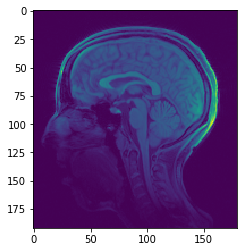

In [42]:
a = anat_data[:,:,25]
pylab.imshow(a)

In [34]:
from ipywidgets import interact

def display_sequence(images):
    def _show(frame=(0, len(images)-1)):
        return display_image(images[frame])
    return interact(_show)

def display_image(x):
    x_scaled = np.uint8(255 * (x / anat_data.max()))
    return Image.fromarray(x_scaled)

In [38]:
# image manipulation
anat_data = anat.get_data()
anat_data = np.rot90(anat_data, axes=(0,2))
#anat_data = np.rot90(anat_data, k=2, axes=(0,1))

slices = []
for i in range(anat_data.shape[2]):
    slices.append(anat_data[:,:,i])
display_sequence(slices)

interactive(children=(IntSlider(value=95, description='frame', max=191), Output()), _dom_classes=('widget-interact',))

<function __main__.display_sequence.<locals>._show>